# Installs and Imports
- we will be using sklego's Bayesian Gaussian Mixture Model Classifier in this notebook

In [1]:
!pip install sklego

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 224 kB 5.1 MB/s 
     |████████████████████████████████| 88 kB 6.4 MB/s 
     |████████████████████████████████| 1.1 MB 37.7 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=948002eae2e226273f402a9754fe78e595422af3e66a38a641dec9db3d89aa37
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=8cbd872905a1a4e608c716797938a28fdea86e7edaafedef80f30b02e871d8e3
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


In [4]:
!cp -f drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [5]:
import os
import gc
import random
import pickle
import numpy as np
import pandas as pd
import kaggle
from tqdm import tqdm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline

from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.mixture import BayesianGaussianMixture
from sklego.mixture import BayesianGMMClassifier

import warnings # suppress warnings
warnings.filterwarnings('ignore')

# Configuration

In [38]:
class CFG:
    path = 'drive/MyDrive/Kaggle/Clustering_072022/'
    n_components = 7
    alpha = 0.005
    max_iter = 1000
    n_init=3
    tol = 0.0001
    seed = 0
    prob_coef = 1.0
    prob1_coef = 0.99
    prob2_coef = 0.93
    prob3_coef = 0.88

# Loading+Transforming+Data & Normality Filter

In [39]:
data = pd.read_csv(CFG.path + 'src/data.csv', index_col='id')
cols = data.columns.tolist()

select_cols = []
for col in cols:
    _, p_value = stats.shapiro(data[col])
    if p_value <= CFG.alpha:
        select_cols.append(col)
print(select_cols)

df = data[select_cols]

dfs = pd.DataFrame(PowerTransformer().fit_transform(df), columns=df.columns)
dfs

['f_07', 'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']


# Loading and Analyzing Sub Prime and Supports
The sub prime df is just our highest scoring predictions. For the sub prime and any support predictions, we may need to subtract 1 from the predictions to make them start at 0.

## Sub Prime

In [62]:
sub_prime = pd.read_csv(CFG.path + 'submissions/fine_art.csv', index_col='Id')
sub_prime['Predicted'].value_counts()

3    16358
5    16343
6    14699
1    13775
4    13018
7    12524
2    11283
Name: Predicted, dtype: int64

2    16410
4    16210
5    14802
0    13878
3    12958
6    12437
1    11305
Name: Predicted, dtype: int64

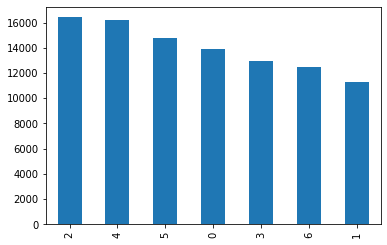

In [59]:
sub_prime['Predicted'].value_counts().plot(kind='bar')
sub_prime['Predicted'].value_counts()

## Support #1

In [63]:
support1 = pd.read_csv(CFG.path + 'submissions/semi_supervised.csv', index_col='Id')
support1['Predicted'].value_counts()

3    16778
1    15776
5    15063
2    14217
6    12855
4    11935
7    11376
Name: Predicted, dtype: int64

2    16778
0    15776
4    15063
1    14217
5    12855
3    11935
6    11376
Name: Predicted, dtype: int64

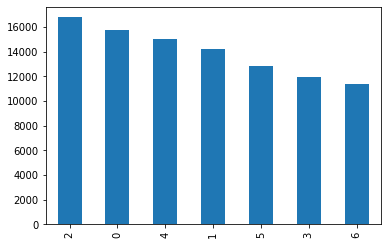

In [64]:
support1['Predicted'] += -1

support1['Predicted'].value_counts().plot(kind='bar')
support1['Predicted'].value_counts()

## Support #2


In [65]:
support2 = pd.read_csv(CFG.path + 'submissions/voting_classifier.csv', index_col='Id')

support2['Predicted'].value_counts()

4    16355
5    16331
2    14769
1    13701
6    12988
3    12532
7    11324
Name: Predicted, dtype: int64

3    16355
4    16331
1    14769
0    13701
5    12988
2    12532
6    11324
Name: Predicted, dtype: int64

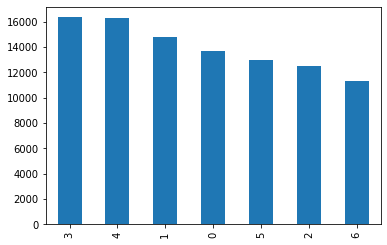

In [66]:
support2['Predicted'] += -1

support2['Predicted'].value_counts().plot(kind='bar')
support2['Predicted'].value_counts()

## Support #3

In [67]:
support3 = pd.read_csv(CFG.path + 'submissions/ensemble#4#2-afterupdate(20).csv', index_col='Id')

support3['Predicted'].value_counts()

2    16414
3    16280
7    14796
1    13745
5    12842
4    12578
6    11345
Name: Predicted, dtype: int64

1    16414
2    16280
6    14796
0    13745
4    12842
3    12578
5    11345
Name: Predicted, dtype: int64

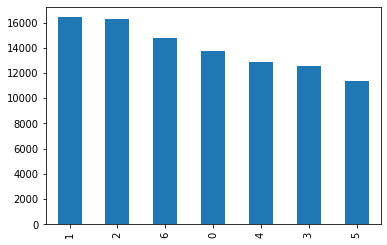

In [68]:
support3['Predicted'] += -1
support3['Predicted'].value_counts().plot(kind='bar')
support3['Predicted'].value_counts()

# Bayesian Gaussian Mixture Model Classifier

In [49]:
X = np.array(dfs)
y = np.array(sub_prime)

s1 = np.array(support1)
s2 = np.array(support2)
s3 = np.array(support3)

In [50]:
# We fit and predict probabilities using our dataframe from the start and each of the prediction sets seperately
bgmmc = BayesianGMMClassifier(n_components=CFG.n_components, random_state=1234, max_iter=CFG.max_iter, n_init=CFG.n_init, tol=CFG.tol)

bgmmc.fit(X, y)
proba = bgmmc.predict_proba(X)

bgmmc.fit(X, s1)
probs1 = bgmmc.predict_proba(X)

bgmmc.fit(X, s2)
probs2 = bgmmc.predict_proba(X)

bgmmc.fit(X, s3)
probs3 = bgmmc.predict_proba(X)

proba.shape, probs1.shape, probs2.shape, probs3.shape

((98000, 7), (98000, 7), (98000, 7), (98000, 7))

# Weighted Concatenation
To combine these sets of probabilities we concatenate them together, multiplying the lower scoring predictions by a ratio less than 1 to give them less weight in the final model.

In [51]:
prob = np.concatenate((proba, probs1*CFG.prob1_coef, probs2*CFG.prob2_coef, probs3*CFG.prob3_coef), axis=1)
prob.shape

(98000, 28)

In [52]:
preds = np.argmax(prob, axis=1)
preds, min(preds), max(preds)

(array([ 0,  6,  5, ..., 11,  1,  4]), 0, 27)

# Mapping Clusters
Now we need to map the array of weighted probabilities to the original clusters. We do this by creating a 7x7 matrix where the rows axis is the sub prime clusters and column axis is the support clusters. Then simply fill in the matrix with a count of how many times each support cluster coincides with each sub prime cluster. The final mapping is the argmax of each column, mapped onto its respective portion of the probability array.

## Part 1

In [71]:
clusters = np.zeros(shape=(7, 7), dtype=int)
for n1, n2 in zip(y, s1):
    clusters[n1, n2] += 1
print(clusters)

max_clusters = np.argmax(clusters, axis=0)

for i in range(len(preds)):
    if preds[i] == 7:
        preds[i] = max_clusters[0]
    if preds[i] == 8:
        preds[i] = max_clusters[1]
    if preds[i] == 9:
        preds[i] = max_clusters[2]
    if preds[i] == 10:
        preds[i] = max_clusters[3]
    if preds[i] == 11:
        preds[i] = max_clusters[4]
    if preds[i] == 12:
        preds[i] = max_clusters[5]
    if preds[i] == 13:
        preds[i] = max_clusters[6]

preds, min(preds), max(preds)

[[   33 13518    70    24    81    10    39]
 [   31    23    48    24    12    15 11130]
 [   30    20 16149    33    65    34    27]
 [   10    10    93    66   167 12651    21]
 [15613   521    60    29    10    15    95]
 [    7    27    78    27 14448    86    26]
 [   52    98   280 11732   280    44    38]]


(array([0, 6, 5, ..., 5, 1, 4]), 0, 6)

## Part 2

In [54]:
clusters = np.zeros(shape=(7, 7), dtype=int)
for n1, n2 in zip(y, s2):
    clusters[n1, n2] += 1

max_clusters = np.argmax(clusters, axis=0)

for i in range(len(preds)):
    if preds[i] == 14:
        preds[i] = max_clusters[0]
    if preds[i] == 15:
        preds[i] = max_clusters[1]
    if preds[i] == 16:
        preds[i] = max_clusters[2]
    if preds[i] == 17:
        preds[i] = max_clusters[3]
    if preds[i] == 18:
        preds[i] = max_clusters[4]
    if preds[i] == 19:
        preds[i] = max_clusters[5]
    if preds[i] == 20:
        preds[i] = max_clusters[6]

preds, min(preds), max(preds)

(array([0, 6, 5, ..., 5, 1, 4]), 0, 27)

## Part 3

In [55]:
clusters = np.zeros(shape=(7, 7), dtype=int)
for n1, n2 in zip(y, s3):
    clusters[n1, n2] += 1

max_clusters = np.argmax(clusters, axis=0)

for i in range(len(preds)):
    if preds[i] == 21:
        preds[i] = max_clusters[0]
    if preds[i] == 22:
        preds[i] = max_clusters[1]
    if preds[i] == 23:
        preds[i] = max_clusters[2]
    if preds[i] == 24:
        preds[i] = max_clusters[3]
    if preds[i] == 25:
        preds[i] = max_clusters[4]
    if preds[i] == 26:
        preds[i] = max_clusters[5]
    if preds[i] == 27:
        preds[i] = max_clusters[6]

preds, min(preds), max(preds)

(array([0, 6, 5, ..., 5, 1, 4]), 0, 6)

# Visualizing Changes
Plotting the sub prime and final submission's distribution allows us to visualize where any changes took place.

In [56]:
hist_data = [sub_prime.iloc[:, 0], preds]
group_data = ['Sub-Prime', 'Submission']

fig = ff.create_distplot(hist_data, group_data, bin_size=.2, show_hist=False, show_rug=False) 
fig.show()

# Submission

In [57]:
sample = pd.read_csv(CFG.path + 'submissions/sample_submission.csv', index_col='Id')
sample['Predicted'] = preds
sample.to_csv(CFG.path + 'submissions/submission_ensemble#5_1.0-0.99-0.93-0.88.csv', index='Id')